In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

from tf_lab.point_clouds.encoders_decoders import knn,\
encoder_with_dynamic_edge_convolutions, get_edge_feature, pairwise_distance

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
experiment_tag = 'edge_conv_test_1'
loss = 'chamfer'
n_pc_points = 2048
random_seed = 42
bneck_list = [128]
class_name = 'chair'

In [5]:
syn_id = snc_category_to_synth_id()[class_name]
in_data = load_multiple_version_of_pcs('uniform_one' ,syn_id, n_classes=1, n_pc_points=n_pc_points)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [182]:
train_params = default_train_params()

for bneck in bneck_list:
    experiment_id = '_'.join(['ae', class_name, experiment_tag, str(n_pc_points), 'pts', str(bneck), 'bneck', loss])
    train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', experiment_id)
    create_dir(train_dir)
    reset_tf_graph()    

    encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck)
    
    encoder = encoder_with_dynamic_edge_convolutions
    enc_args['b_norm'] =  [True, False, True, False, True, False]
    enc_args['n_filters'] = [32, 64, 128, 256, 256, 128] 
#     enc_args['n_filters'] = [16, 16, 16, 16, 16] 
#     enc_args['neighbs']   = [0, 100, 0, 20, 0, 10]
    enc_args['neighbs']   = [10]

    conf = Conf(n_input = [n_pc_points, 3],
                loss = loss,
                training_epochs = 500,
                batch_size = train_params['batch_size'],
                denoising = False,
                learning_rate = train_params['learning_rate'],
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = train_params['saver_step'],
                z_rotate = False,
                encoder = encoder,
                decoder = decoder,
                encoder_args = enc_args,
                decoder_args = dec_args
               )
    print conf
    conf.experiment_name = 'experiment_' + str(experiment_id)
    conf.held_out_step = 5
#     conf.save(osp.join(train_dir, 'configuration'))

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'b_norm_finish': False, 'verbose': True, 'b_norm': False, 'layer_sizes': [256, 256, 6144]}
                       encoder: encoder_with_dynamic_edge_convolutions
                  encoder_args: {'verbose': True, 'strides': [1], 'filter_sizes': [1], 'n_filters': [32, 64, 128, 256, 256, 128], 'b_norm': [True, False, True, False, True, False], 'neighbs': [10]}
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_

In [184]:
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

/orions4-zfs/projects/optas/Virt_Env/tf_1.3/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [161]:
conf.batch_size = 50
buf_size = 1 # flush each line
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
#     train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['val'])
train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['test'])
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.4039', 'loss=', '0.067589308')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_edge_conv_test_1_2048_pts_128_bneck_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.3940', 'loss=', '0.032949398')
('Epoch:', '0003', 'training time (minutes)=', '0.3942', 'loss=', '0.015297703')
('Epoch:', '0004', 'training time (minutes)=', '0.3953', 'loss=', '0.008884500')
('Epoch:', '0005', 'training time (minutes)=', '0.3960', 'loss=', '0.006561388')
('Held Out Data :', 'forward time (minutes)=', '0.0386', 'loss=', '0.005944848')
('Epoch:', '0006', 'training time (minutes)=', '0.3962', 'loss=', '0.005619298')
('Epoch:', '0007', 'training time (minutes)=', '0.3964', 'loss=', '0.005043561')
('Epoch:', '0008', 'training time (minutes)=', '0.3966', 'loss=', '0.004603416')
('Epoch:', '0009', 'training time (minutes)=', '0.3947', 'loss=', '0.004465290

KeyboardInterrupt: 

In [174]:
in_feed = in_data['test'].point_clouds[:50]
out_feed = ae.sess.run(ae.z, feed_dict={ae.x: in_feed})

In [175]:
out_feed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

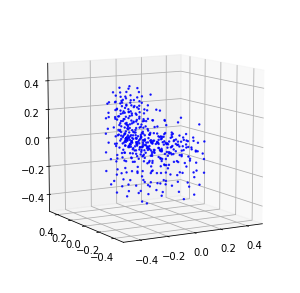

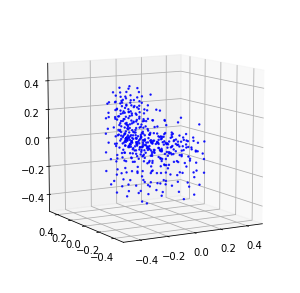

In [173]:
# Point_Cloud(out_feed[4]).plot()

In [94]:
from tflearn.layers.conv import conv_1d

In [98]:
in_features = data
n_clusters = 3
class_scores = conv_1d(tf.expand_dims(in_features, 1), nb_filter=n_clusters, filter_size=1)
class_scores = tf.nn.softmax(class_scores)
_, nn_idx = tf.nn.top_k(class_scores, k=1)

In [118]:
data

<tf.Tensor 'Const_57:0' shape=(4, 5) dtype=float32>

In [119]:
idx

<tf.Tensor 'Const_58:0' shape=(4,) dtype=int32>

In [135]:
with tf.Session() as sess:    
    data = tf.constant([[0.2, 0.1, 0.5, 0.7, 0.8],
                        [0.2, 0.2, 0.5, 0.7, 0.8],
                        [0.9, 0.2, 0.5, 0.7, 0.8],
                        [0.2, 0.1, 0, 0.7, 1],
                       ])
    idx = tf.constant([0, 0, 2, 2])
    print data, idx
    result = tf.unsorted_segment_max(data, idx, 3)    
    print result
#     result = tf.transpose(tf.unsorted_segment_max(tf.transpose(data), idx, 3))
#     clk = tf.nn.softmax(data)
    print(sess.run(result))
    
#     a = (sess.run(clk))
#     print a

Tensor("Const_4:0", shape=(4, 5), dtype=float32) Tensor("Const_5:0", shape=(4,), dtype=int32)
Tensor("UnsortedSegmentMax_2:0", shape=(3, 5), dtype=float32)
[[ 2.0000000e-01  2.0000000e-01  5.0000000e-01  6.9999999e-01
   8.0000001e-01]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
  -3.4028235e+38]
 [ 8.9999998e-01  2.0000000e-01  5.0000000e-01  6.9999999e-01
   1.0000000e+00]]


In [90]:
np.sum(a,1)

array([1.       , 0.9999999, 1.       , 1.       ], dtype=float32)

In [61]:
tf.unsorted_segment_sum(tf.constant([0.2, 0.1, 0.5, 0.7, 0.8]),
                        tf.constant([0, 0, 1, 2, 2]), 3)



<tf.Tensor 'UnsortedSegmentSum:0' shape=(3,) dtype=float32>

In [ ]:
from tf_lab.fundamentals.inspect import operations_of_graph, count_trainable_parameters
from tf_lab.point_clouds.encoders_decoders import encoder_with_dynamic_edge_convolutions, get_edge_feature, knn, pairwise_distance, soft_maxed_edge
from tflearn.layers.conv import conv_1d, conv_2d

In [284]:
in_pc = tf.placeholder(tf.float32, [None, 2048, 3])
new_op = soft_maxed_edge(in_pc)
in_feed = in_data['test'].point_clouds[:50]
out_feed = ae.sess.run(new_op, feed_dict={in_pc: in_feed})

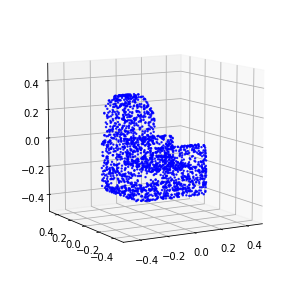

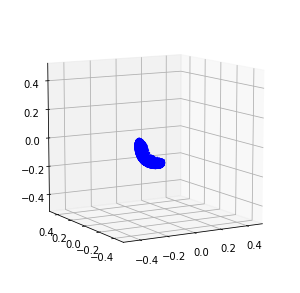

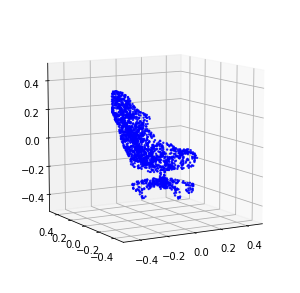

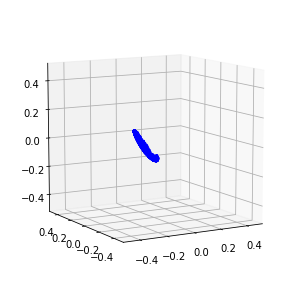

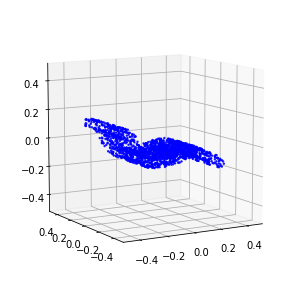

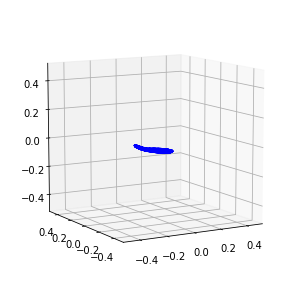

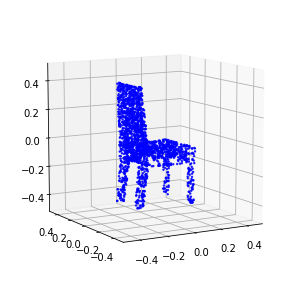

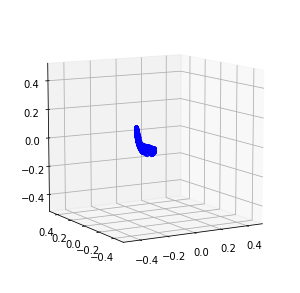

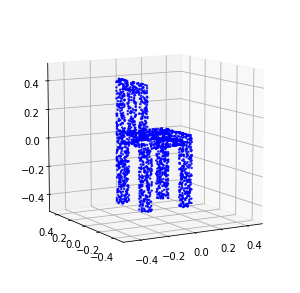

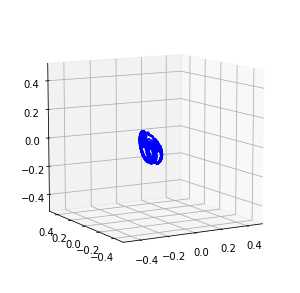

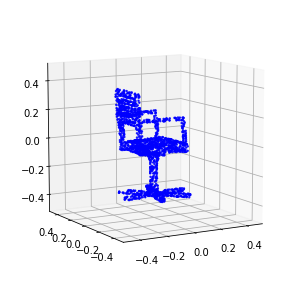

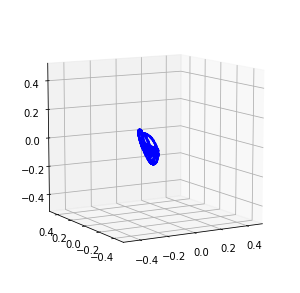

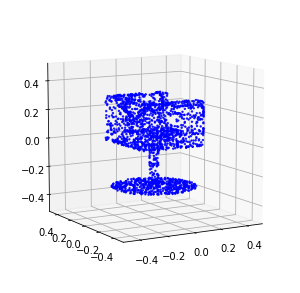

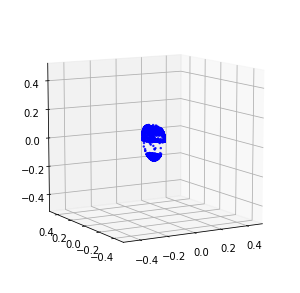

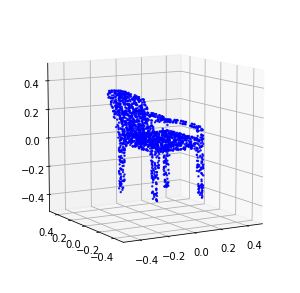

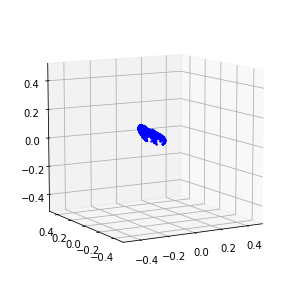

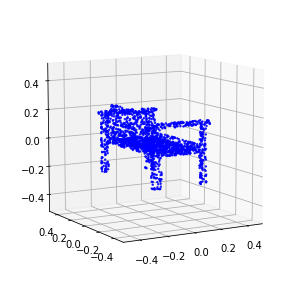

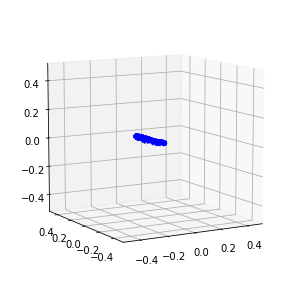

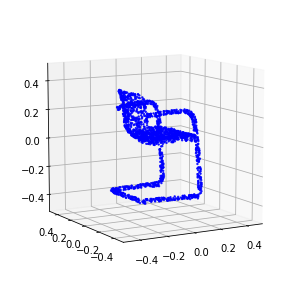

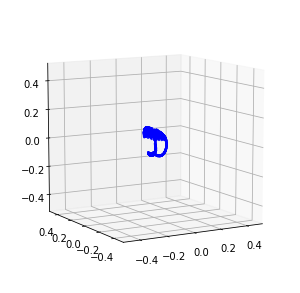

In [285]:
for j in range(10):
    Point_Cloud(in_feed[j]).plot();
    Point_Cloud(out_feed[j]).plot();